In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
%matplotlib inline
import math
import time
import datetime

import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
from pandas import datetime
from pandas_datareader import data

stock = 'AAPL'
start = datetime(2016,3,19)
end = datetime(2018,3,26)

df = data.DataReader(stock, 'iex', start, end)

y = df['close']
y1 = y.iloc[1:]
y1 = (np.append(y1,[0]))
y2 = y.iloc[5:]
y2 = (np.append(y2,[0,0,0,0,0]))
df['price+1'] = y1 #future price
df['price+5'] = y2

df.head()

5y


,open,high,low,close,volume,price+1,price+5
date,,,,,,,
2016-03-21,102.1213,103.7794,101.3598,102.1020,35502678,102.8829,103.8084
2016-03-22,101.4657,103.4324,101.4272,102.8829,32444375,102.3141,105.6208
2016-03-23,102.6515,103.2203,102.0924,102.3141,25703495,101.8706,105.0713
2016-03-24,101.6778,102.4298,101.1187,101.8706,26132955,101.4079,106.0353
2016-03-28,102.1888,102.3719,101.2826,101.4079,19411372,103.8084,107.1247


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,close,volume,price+1,price+5,macd,rsi_12,volume_delta,MA 20,MA 50,Daily Change,Fluctuation
date,,,,,,,,,,,
2017-01-03,113.8474,28781865,113.7200,116.7488,1.277287,52.196938,-1804400.0,112.612895,110.465704,0.3430,1.368094
2017-01-04,113.7200,21118116,114.2983,117.3761,1.188925,49.671961,-7663749.0,112.951545,110.466010,0.1666,0.656558
2017-01-05,114.2983,22193587,115.5725,116.8860,1.152279,60.167694,1075471.0,113.277945,110.457402,0.6763,0.910283
2017-01-06,115.5725,31751900,116.6311,116.6801,1.212082,74.324962,9558313.0,113.615125,110.462576,1.1076,1.451020
2017-01-09,116.6311,33561948,116.7488,117.6211,1.329570,81.042392,1810048.0,113.951815,110.540802,1.0193,1.263300


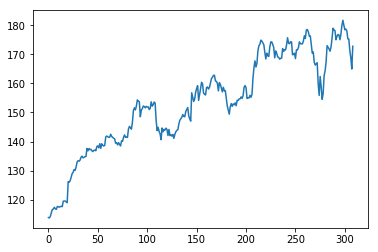

In [3]:
from stockstats import StockDataFrame
df = StockDataFrame.retype(df)
y = df['close']

#generate features with stockstats package
df['macd'] = df.get('macd')
df['rsi_12'] = df.get('rsi_6')
df['volume_delta'] = df.get('volume_delta')
df['MA 20'] = y.rolling(20).mean()
df['MA 50'] = y.rolling(50).mean()
df['Daily Change'] = df['close']-df['open']
df['Fluctuation'] = ((df['high']-df['low'])/df['low'])*100
df.tail(10)
df = pd.DataFrame(df)

X = df.drop(['open', 'high', 'low', 'macdh', 'macds', 'close_-1_s', 'close_-1_d', 'rs_6', 'rsi_6', 'close_12_ema', 'close_26_ema'], axis=1)
X_shape = X.shape[0]
X1 = X['20160103':]
y = X1['close']
y_max = np.max(np.array(y))
y_min = np.min(np.array(y))
plt.plot(np.array(y))
X1.head()



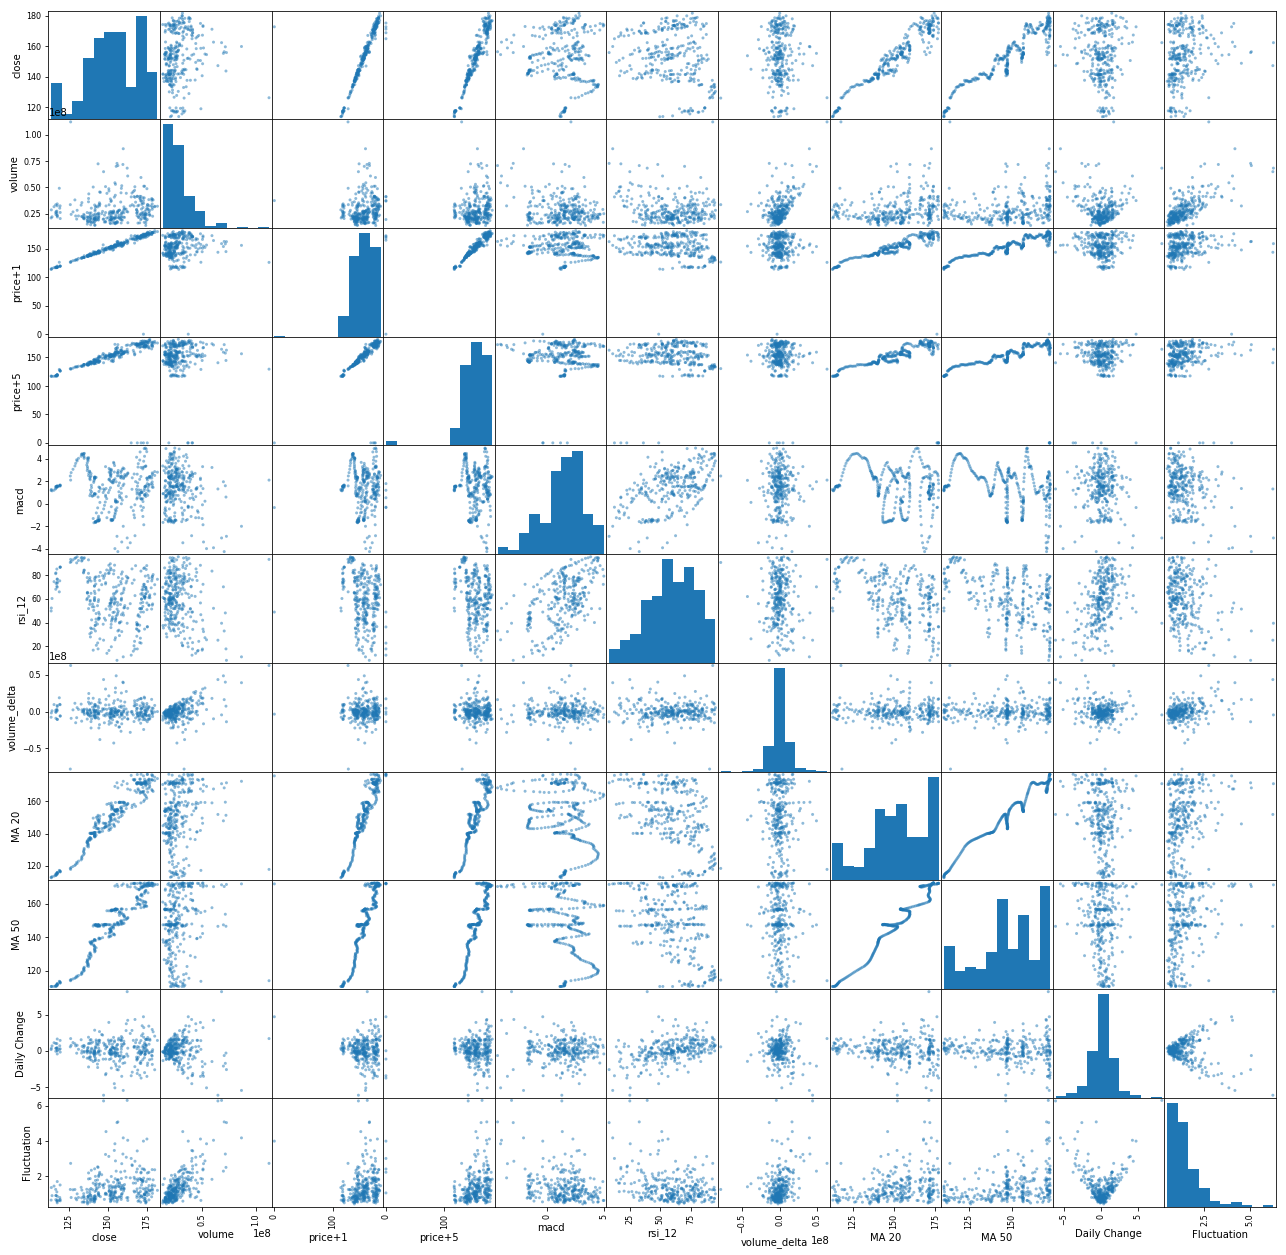

In [4]:
from pandas.plotting import scatter_matrix
scatter_matrix(X1,figsize=(22,22))
plt.show()

- As seen above, there does not seem to be much related correlations to that of the closing price and future prices except that of the moving averages. Therefore, we can see that this data does not follow any linear trend

In [5]:
from sklearn.preprocessing import MinMaxScaler

def normalize_df(df):
    normalize_data = MinMaxScaler()
    for i in range(0,df.shape[1]):
        df.iloc[:,i] = normalize_data.fit_transform(df.iloc[:,i].values.reshape(-1,1))
    return df

def coeff_determination(y_true,y_pred):
    SS_res = np.sum((y_true-y_pred)**2)
    SS_tot = np.sum((y_true-np.mean(y_true))**2)
    return(np.abs(1-SS_res/(SS_tot+1e-18)))


In [6]:
X2 = normalize_df(X1)
y_normal = X2['close']


X3 = X2.drop(['close','price+1','price+5'], axis = 1)
print(X3.shape)
X3.tail(10)

D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


(309, 8)


,volume,macd,rsi_12,volume_delta,MA 20,MA 50,Daily Change,Fluctuation
date,,,,,,,,
2018-03-13,0.180351,0.772664,0.639817,0.551268,0.971340,0.987979,0.245965,0.329905
2018-03-14,0.156614,0.760396,0.532662,0.538425,0.982301,0.991169,0.297694,0.184713
2018-03-15,0.088988,0.749200,0.544918,0.507945,0.991069,0.993455,0.439599,0.132683
2018-03-16,0.259069,0.731690,0.495103,0.673021,0.994979,0.995547,0.385074,0.068982
2018-03-19,0.198248,0.691325,0.325568,0.512671,0.997209,0.996506,0.287907,0.298782
2018-03-20,0.057399,0.656561,0.322395,0.457095,0.999845,0.996812,0.429114,0.106229
2018-03-21,0.235082,0.592702,0.166125,0.678301,1.000000,0.996047,0.165575,0.306007
2018-03-22,0.280365,0.520206,0.110056,0.586355,0.997163,0.994509,0.348724,0.337266
2018-03-23,0.275649,0.428857,0.049866,0.551633,0.988954,0.991723,0.187944,0.439331


In [20]:
window = 10 #prediction time-lag window

def load_data(stock,y,window):
    raw_data = stock.as_matrix()
    length = raw_data.shape[0]
    indicators = raw_data.shape[1]    
    prices = y.as_matrix()
    data = []

    for index in range(len(raw_data)-(window)+1):
        data.append(raw_data[index:index+window])
    
    data = np.array(data)
    valid_size = int(np.round(2/100*data.shape[0]))
    test_size = int(1)
    training_size = data.shape[0] - (valid_size + test_size)
    
    X_train = data[:training_size+valid_size,:-1]
    y_train = prices[window-1:training_size+window+valid_size-1]
    
    #validation for time series
    X_valid = data[training_size:training_size+valid_size,:-1]
    y_valid = prices[training_size+window-1:training_size+valid_size+window-1]
    
    #X_valid = data[training_size+valid_size:,:-1]
    #y_valid = prices[-1]
    
    raw_data = raw_data.reshape(1,length,indicators)
    
    X_test = np.zeros((1,window,8))
    for i in range(0,window-1):
        X_test[0,window-1-i,:] = raw_data[0,length-i-1,:]
    X_test = X_test[:,1:,:]
    y_test = 0
    
    return [X_train, y_train, X_valid, y_valid, X_test, y_test]

In [21]:
X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(X3,y_normal,window+1)
print(X_valid.shape)
print(X_test)
print(y_test)

(6, 10, 8)
[[[ 0.18035066  0.7726635   0.63981667  0.55126759  0.97134045  0.98797867
    0.24596478  0.32990465]
  [ 0.15661432  0.76039623  0.53266204  0.53842456  0.98230057  0.99116946
    0.29769386  0.18471287]
  [ 0.08898806  0.74919954  0.544918    0.50794515  0.99106867  0.99345506
    0.43959931  0.1326828 ]
  [ 0.2590694   0.73169042  0.49510275  0.67302148  0.99497855  0.9955472
    0.38507406  0.06898228]
  [ 0.19824849  0.69132485  0.32556818  0.51267114  0.99720944  0.99650558
    0.28790728  0.29878211]
  [ 0.05739864  0.65656135  0.32239534  0.45709495  0.99984454  0.99681208
    0.42911369  0.106229  ]
  [ 0.23508213  0.59270201  0.16612469  0.67830081  1.          0.99604736
    0.165575    0.30600652]
  [ 0.28036496  0.52020564  0.11005596  0.58635501  0.99716281  0.9945089
    0.3487239   0.33726592]
  [ 0.27564885  0.42885735  0.04986551  0.55163318  0.98895437  0.99172272
    0.18794433  0.43933082]
  [ 0.2400465   0.42550994  0.46626467  0.5301842   0.98413503  

In [22]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model

def build_model(layers,neurons,d):
    #d = 0.3
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

model = build_model([X3.shape[1],window,1],[256,256,32,1],0.3)

Compilation Time :  0.013034582138061523


In [29]:
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 268 samples, validate on 30 samples
Epoch 1/90
268/268 [==============================] - 0s 138us/step - loss: 0.0049 - acc: 0.0000e+00 - val_loss: 0.0101 - val_acc: 0.0333
Epoch 2/90
268/268 [==============================] - 0s 135us/step - loss: 0.0051 - acc: 0.0000e+00 - val_loss: 0.0112 - val_acc: 0.0333
Epoch 3/90
268/268 [==============================] - 0s 135us/step - loss: 0.0045 - acc: 0.0000e+00 - val_loss: 0.0146 - val_acc: 0.0333
Epoch 4/90
268/268 [==============================] - 0s 131us/step - loss: 0.0047 - acc: 0.0000e+00 - val_loss: 0.0153 - val_acc: 0.0333
Epoch 5/90
268/268 [==============================] - 0s 138us/step - loss: 0.0045 - acc: 0.0000e+00 - val_loss: 0.0125 - val_acc: 0.0333
Epoch 6/90
268/268 [==============================] - 0s 135us/step - loss: 0.0042 - acc: 0.0000e+00 - val_loss: 0.0116 - val_acc: 0.0333
Epoch 7/90
268/268 [==============================] - 0s 127us/step - loss: 0.0045 - acc: 0.0000e+00 - val_loss: 0.0120 - val_a

Epoch 60/90
268/268 [==============================] - 0s 120us/step - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.0072 - val_acc: 0.0333
Epoch 61/90
268/268 [==============================] - 0s 123us/step - loss: 0.0041 - acc: 0.0000e+00 - val_loss: 0.0107 - val_acc: 0.0333
Epoch 62/90
268/268 [==============================] - 0s 120us/step - loss: 0.0035 - acc: 0.0000e+00 - val_loss: 0.0099 - val_acc: 0.0333
Epoch 63/90
268/268 [==============================] - 0s 127us/step - loss: 0.0034 - acc: 0.0000e+00 - val_loss: 0.0078 - val_acc: 0.0333
Epoch 64/90
268/268 [==============================] - 0s 120us/step - loss: 0.0037 - acc: 0.0000e+00 - val_loss: 0.0070 - val_acc: 0.0333
Epoch 65/90
268/268 [==============================] - 0s 123us/step - loss: 0.0039 - acc: 0.0000e+00 - val_loss: 0.0095 - val_acc: 0.0333
Epoch 66/90
268/268 [==============================] - 0s 142us/step - loss: 0.0041 - acc: 0.0000e+00 - val_loss: 0.0091 - val_acc: 0.0333
Epoch 67/90
268/268 [======

In [30]:
y_validation = model.predict(X_valid)

y_validation_scaled = np.ravel(np.array(y_validation*(y_max-y_min)+y_min))
y_actual_scaled = np.array(np.array(y[309-6:])*(y_max-y_min)+y_min)

RMSE = (np.sum((y_validation_scaled-y_actual_scaled)**(2)))**(0.5)

print(y_validation_scaled)
print(y_actual_scaled)
print(RMSE)

R2 = coeff_determination(y_actual_scaled,y_validation_scaled)
print('R^2 =',R2)

[ 176.08860779  176.02900696  175.59576416  175.15576172  174.41194153
  173.08827209]
[ 175.3   175.24  171.27  168.85  164.94  172.77]
12.2285843043
R^2 = 0.86728295068


- $R^2$ calculated from the validation dataset shows that it is 0.86. Therefore, this model shows that it is somewhat accurate in predicting future stock prices 1 day beforehand. It is also seen that although the predicted numbers do not mean much, but the values increased or decreased from the previous datapoint in the same way as the actual dataset.

In [34]:
y_predict = model.predict(X_test)
y_predict_scaled = y_predict*(y_max-y_min)+y_min
print(y_predict_scaled)

[[ 170.19543457]]


In [35]:
#Decision based on prediction on 3/26 data for 3/27 price
y_check = y[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict_scaled:
    print('Buy')
elif y_check > y_predict_scaled:
    print('Sell if bought')
else:
    print('error')

Based on previous value of: 172.77
Sell if bought


In [36]:
#predict 5 days ahead of time

#adjust stock price
y_normal1 = y_normal[5:]
y_normal1.shape
y_normal1 = np.array(y_normal1)
y_normal2 = pd.DataFrame(np.append(y_normal1,[0,0,0,0,0]))
#y_normal2.head(10)

In [37]:
def load_data(stock,y,window):
    raw_data = stock.as_matrix()
    length = raw_data.shape[0]
    indicators = raw_data.shape[1]    
    prices = y.as_matrix()
    data = []

    for index in range(len(raw_data)-(window)+1):
        data.append(raw_data[index:index+window])
    
    data = np.array(data)
    valid_size = int(np.round(1/100*data.shape[0]))
    test_size = int(1)
    training_size = data.shape[0] - (4 + test_size)
    
    X_train = data[:training_size,:-1]
    y_train = prices[window-1:training_size+window-1]
    
    #no need
    #X_valid = data[training_size:training_size+valid_size,:-1]
    #y_valid = prices[training_size+window-1:training_size+valid_size+window-1]
    
    X_valid = data[training_size+valid_size:,:-1]
    y_valid = prices[-1]
    
    raw_data = raw_data.reshape(1,length,indicators)
    
    X_test = np.zeros((1,window,8))
    for i in range(0,window-1):
        X_test[0,window-1-i,:] = raw_data[0,length-i-1,:]
    X_test = X_test[:,1:,:]
    y_test = 0
    
    return [X_train, y_train, X_valid, y_valid, X_test, y_test]



X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(X3,y_normal2,window+1)

In [38]:
model.fit(X_train,y_train,batch_size=512,epochs=100,validation_split=0.1,verbose=1)

Train on 264 samples, validate on 30 samples
Epoch 1/100
264/264 [==============================] - 0s 144us/step - loss: 0.0066 - acc: 0.0000e+00 - val_loss: 0.0140 - val_acc: 0.0333
Epoch 2/100
264/264 [==============================] - 0s 144us/step - loss: 0.0073 - acc: 0.0000e+00 - val_loss: 0.0172 - val_acc: 0.0333
Epoch 3/100
264/264 [==============================] - 0s 137us/step - loss: 0.0055 - acc: 0.0000e+00 - val_loss: 0.0221 - val_acc: 0.0333
Epoch 4/100
264/264 [==============================] - 0s 133us/step - loss: 0.0062 - acc: 0.0000e+00 - val_loss: 0.0190 - val_acc: 0.0333
Epoch 5/100
264/264 [==============================] - 0s 133us/step - loss: 0.0067 - acc: 0.0000e+00 - val_loss: 0.0147 - val_acc: 0.0333
Epoch 6/100
264/264 [==============================] - 0s 129us/step - loss: 0.0065 - acc: 0.0000e+00 - val_loss: 0.0201 - val_acc: 0.0333
Epoch 7/100
264/264 [==============================] - 0s 133us/step - loss: 0.0060 - acc: 0.0000e+00 - val_loss: 0.0258 

Epoch 60/100
264/264 [==============================] - 0s 125us/step - loss: 0.0052 - acc: 0.0000e+00 - val_loss: 0.0167 - val_acc: 0.0333
Epoch 61/100
264/264 [==============================] - 0s 118us/step - loss: 0.0049 - acc: 0.0000e+00 - val_loss: 0.0144 - val_acc: 0.0333
Epoch 62/100
264/264 [==============================] - 0s 129us/step - loss: 0.0050 - acc: 0.0000e+00 - val_loss: 0.0145 - val_acc: 0.0333
Epoch 63/100
264/264 [==============================] - 0s 122us/step - loss: 0.0058 - acc: 0.0000e+00 - val_loss: 0.0163 - val_acc: 0.0333
Epoch 64/100
264/264 [==============================] - 0s 125us/step - loss: 0.0055 - acc: 0.0000e+00 - val_loss: 0.0169 - val_acc: 0.0333
Epoch 65/100
264/264 [==============================] - 0s 118us/step - loss: 0.0051 - acc: 0.0000e+00 - val_loss: 0.0157 - val_acc: 0.0333
Epoch 66/100
264/264 [==============================] - 0s 129us/step - loss: 0.0048 - acc: 0.0000e+00 - val_loss: 0.0147 - val_acc: 0.0333
Epoch 67/100
264/264

In [39]:
y_predict = model.predict(X_test)
y_predict_scaled = y_predict*(y_max-y_min)+y_min
print(y_predict_scaled)

#Decision based on prediction for 4/3
y_check = y[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict_scaled:
    print('Buy')
elif y_check > y_predict_scaled:
    print('Sell if bought')
else:
    print('error')

[[ 168.27349854]]
Based on previous value of: 172.77
Sell if bought


- Outputted correct decision for this value 